In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.integrate as scpi

import os 

import cbmos
import cbmos.force_functions as ff
import cbmos.solvers.euler_forward as ef
import cbmos.cell as cl

plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6.75, 5),
          'lines.linewidth': 3.0, 
          'axes.labelsize': 'xx-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'xx-large', 
          'ytick.labelsize':'xx-large', 
          'legend.fontsize': 'xx-large', 
          'font.size': 11, 
          'font.family': 'serif', 
          'mathtext.fontset': 'dejavuserif', 
          'axes.titlepad': 12, 
          'axes.labelpad': 12}
plt.rcParams.update(params)

In [2]:
# Simulation parameters
s = 1.0    # rest length
tf = 7.5  # final time
rA = 1.5   # maximum interaction distance
#dim = 2
dim = 1
seed=67

dt = 0.05
t_data = [0,tf]

#force_names = ['cubic', 'pw. quad.', 'GLS']
force_names = ['cubic']

defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {'cubic': defcolors[0], 'pw. quad.': defcolors[5], 'GLS': defcolors[6]}

# Solvers
models_ef = {'pw. quad.': cbmos.CBModel(ff.PiecewisePolynomial(), ef.solve_ivp, dim), 
             'cubic': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),
             'GLS': cbmos.CBModel(ff.Gls(), ef.solve_ivp, dim)}
#models_ef = {'pw. quad.': cbmos.CBModel(ff.PiecewisePolynomial(), ef.solve_ivp, dim), 
#             'cubic': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),
 #            'GLS': cbmos.CBModel(ff.LinearExponential(), ef.solve_ivp, dim)}

In [3]:
# parameters fitted to relaxation time t=1.0h
params_cubic = {"mu": 5.70, "s": s, "rA": rA}
muR = 9.1
ratio = 0.21
params_poly = {'muA': ratio*muR, 'muR': muR, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(ratio)/3.0), 'n': 1.0, 'p': 1.0}
mu_gls=1.95
params_gls = {'mu': mu_gls, 'a':-2*np.log(0.002/mu_gls)}
params = {'cubic': params_cubic, 'pw. quad.': params_poly, 'GLS': params_gls}
filename_ending = {'cubic': '_cubic', 'pw. quad.': '_pwq', 'GLS': '_gls'}

In [4]:
def cubic_prime(r, mu, s, rA):
    return mu*(r-rA)*(3*r-2*s-rA)
    
def pwq_prime(r, muA, rA, muR, rR, s):
    return 2*(muR/rR*(1-r/rR)-muA/rA*(1-r/rA))
    
def gls_prime(r, mu, s):
    return mu/(1+r-s)

# Adaptive time-stepping for two cells after proliferation

In [5]:
cell_list = [cl.Cell(0, [0], proliferating=False), cl.Cell(1, [0.3], proliferating=False)]

In [6]:
# g'(s) for different force laws
gp_cubic = params_cubic['mu']*(s-rA)**2
rR = params_poly['rR']
muA = params_poly['muA']
gp_PWQ = 2*(muR/rR*(1-s/rR)-muA/rA*(1-s/rA))
gp_GLS = params_gls['mu']

print('Analytical stability bounds:')
print('Cubic '+ str(1.0/gp_cubic))
print('PWQ '+ str(1.0/gp_PWQ))
print('GLS '+ str(1.0/gp_GLS))


Analytical stability bounds:
Cubic 0.7017543859649122
PWQ 0.6639683340575724
GLS 0.5128205128205129


## Convergence study

In [7]:
import scipy.interpolate as sci

In [8]:
force = 'cubic'

In [9]:
dt_ref = 0.00005
tf = 3.0

N_ref = int(1/dt_ref*tf)+1

t_data_ref, history = models_ef[force].simulate(
            cell_list,
            [0, tf],
            params[force],
            {'dt': dt_ref},
            raw_t=True,
        )

ref_traj = np.array(
            [
                [cell.position for cell in cell_list]
                for cell_list in history
            ]
        ) # (N_ref, n_cells, dim)

In [10]:
from matplotlib import cm
import matplotlib.colors as mcolors

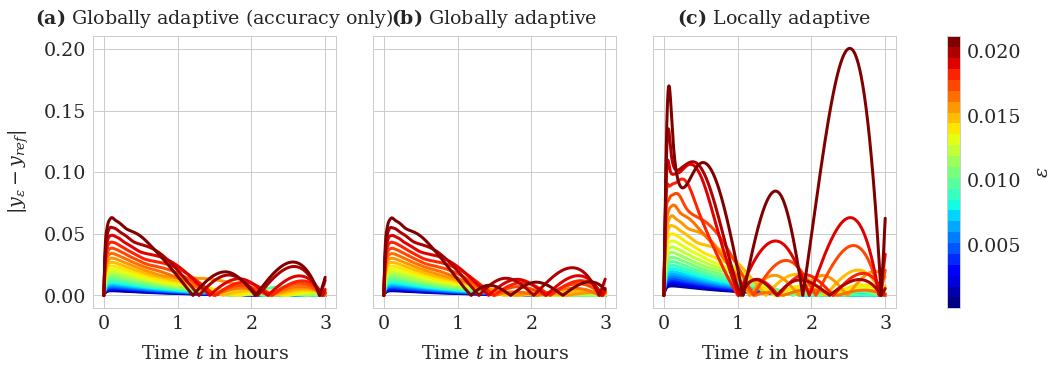

In [14]:
# Combine into single figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey='row', gridspec_kw={'hspace':0.2, 'wspace': 0.15})



eps_values = np.array([0.0001*1.25**n for n in range(0, 25)])
map_eps_values_to_unit_interval = [ np.log(10000*(x-np.min(range(0, 25))))/(np.max(range(0, 25))-np.min(range(0, 25)))/np.log(1.25) for x in eps_values]
colors = [ cm.jet(x) for x in map_eps_values_to_unit_interval ]

sol_global_adap_acc_only = []
for i, eps in enumerate(eps_values):
    N = int(1/dt*tf) + 1
    
    t_data_sol, history = models_ef[force].simulate(
        cell_list,
        [0,tf],
        params[force],
        {'eps': eps},
        raw_t=True,
    )

    traj = np.array([
        [cell.position for cell in cell_list]
        for cell_list in history
    ]) # (N, n_cells, dim)
    
    
    
    interp = sci.interp1d(
        t_data_sol, traj,
        axis=0,
        bounds_error=False, kind='cubic',
        fill_value=tuple(traj[[0, -1], :, :])
    )(t_data_ref[:])
    error = (
        np.linalg.norm(
            interp - ref_traj,
            axis=0)
        /np.linalg.norm(
            ref_traj,
            axis=0)
    ).mean(axis=0)
    
    ax1.plot(t_data_ref, np.abs((interp[:, 1, 0] - interp[:, 0,0])  - (ref_traj[:, 1, 0]-ref_traj[:,0,0])), color=colors[i])
    ax1.set(xlabel='Time $t$ in hours')
    ax1.set(ylabel='$|y_{\epsilon}-y_{ref}|$')
    ax1.set_title(r'$\bf{(a)}$ Globally adaptive (accuracy only)')
    #plt.legend()
    
    sol_global_adap_acc_only.append(error)

sol_global_adap = []
for i, eps in enumerate(eps_values):
    N = int(1/dt*tf) + 1
    
    t_data_sol, history = models_ef[force].simulate(
        cell_list,
        [0,tf],
        params[force],
        {'eps': eps, 'jacobian': models_ef[force].jacobian, 'force_args': params[force]},
        raw_t=True,
    )

    traj = np.array([
        [cell.position for cell in cell_list]
        for cell_list in history
    ]) # (N, n_cells, dim)
    
    
    
    interp = sci.interp1d(
        t_data_sol, traj,
        axis=0,
        bounds_error=False, kind='cubic',
        fill_value=tuple(traj[[0, -1], :, :])
    )(t_data_ref[:])
    error = (
        np.linalg.norm(
            interp - ref_traj,
            axis=0)
        /np.linalg.norm(
            ref_traj,
            axis=0)
    ).mean(axis=0)
    
    ax2.plot(t_data_ref, np.abs((interp[:, 1, 0] - interp[:, 0,0])  - (ref_traj[:, 1, 0]-ref_traj[:,0,0])), color=colors[i])
    ax2.set(xlabel='Time $t$ in hours')
#    ax2.set(ylabel='$|y_{\epsilon}-y_{ref}|$')
    ax2.set_title(r'$\bf{(b)}$ Globally adaptive')
    #plt.legend()
    
    sol_global_adap.append(error)

sol_local_adap = []   
for i, eps in enumerate(eps_values):
    N = int(1/dt*tf) + 1
    
    t_data_sol, history = models_ef[force].simulate(
        cell_list,
        [0,tf],
        params[force],
        {'eps': eps, 'jacobian': models_ef[force].jacobian, 'force_args': params[force], 'local_adaptivity': True, 'update_F': True},
#        {'eps': eps, 'local_adaptivity': True, 'update_F': True},
        raw_t=True,
    )

    traj = np.array([
        [cell.position for cell in cell_list]
        for cell_list in history
    ]) # (N, n_cells, dim)
    
    
    
    interp = sci.interp1d(
        t_data_sol, traj,
        axis=0,
        bounds_error=False, kind='cubic',
        fill_value=tuple(traj[[0, -1], :, :])
    )(t_data_ref[:])
    error = (
        np.linalg.norm(
            interp - ref_traj,
            axis=0)
        /np.linalg.norm(
            ref_traj,
            axis=0)
    ).mean(axis=0)
    
    ax3.plot(t_data_ref, np.abs((interp[:, 1, 0] - interp[:, 0,0])  - (ref_traj[:, 1, 0]-ref_traj[:,0,0])), color=colors[i])
    ax3.set(xlabel='Time $t$ in hours')
    ax3.set_title(r'$\bf{(c)}$ Locally adaptive')
    #ax2.set(ylabel='$|y_{eps}-y_{ref}|$')
    #plt.legend()


    sol_local_adap.append(error)
cma = mcolors.ListedColormap(colors, name='from_list', N=None) # creation of a user cmap
msm = cm.ScalarMappable(cmap=cma) 
msm.set_array(eps_values) 
cbar = fig.colorbar(msm, ax=[ax1, ax2, ax3])
cbar.set_label('$\epsilon$', rotation=90)

plt.savefig('convergence_error_2cells.pdf', bbox_inches='tight')

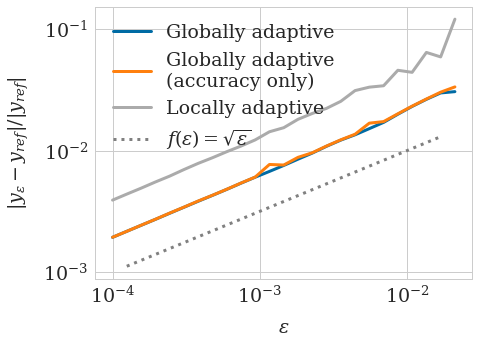

In [15]:
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey='row', gridspec_kw={'hspace':0.2, 'wspace': 0.15})


plt.loglog(eps_values, sol_global_adap, '-', label='Globally adaptive')
plt.loglog(eps_values, sol_global_adap_acc_only, '-', label='Globally adaptive \n(accuracy only)')

plt.loglog(eps_values, sol_local_adap, '-', label='Locally adaptive')

plt.loglog(eps_values[1:-1], eps_values[1:-1]**0.5*0.1, ':',
           label='$f(\epsilon)= \sqrt{\epsilon}$', color='grey')
plt.xlabel('$\epsilon$')
plt.ylabel('$|y_{\epsilon}-y_{ref}|/|y_{ref}|$')
plt.legend()
plt.grid(True)

#ax1.loglog(eps_values, sol_global_adap, '-*')
#ax1.loglog(eps_values[1:-2], eps_values[1:-2]**0.5*0.1, ':',
#           label='$f(\epsilon)= \sqrt{\epsilon}$', color='grey')
#ax1.set(xlabel='$\epsilon$')
#ax1.set(ylabel='$|y_{eps}-y_{ref}|/|y_{ref}|$')
#ax1.legend()

#ax2.loglog(eps_values, sol_local_adap, '-*')
#ax2.loglog(eps_values[1:-2], eps_values[1:-2]**0.5*0.1, ':',
#           label='$f(\epsilon)= \sqrt{\epsilon}$', color='grey')
#ax2.set(xlabel='$\epsilon$')
#ax2.set(ylabel='$|y_{eps}-y_{ref}|/|y_{ref}|$')
#ax2.legend()

plt.savefig('convergence_order_2cells.pdf', bbox_inches='tight')

[]

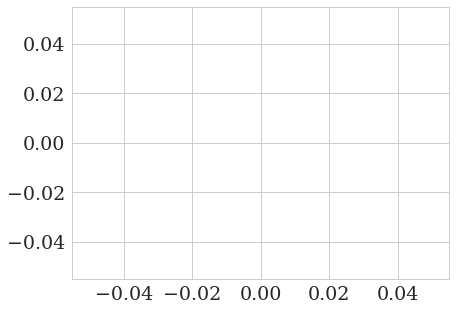

In [14]:
plt.plot()

In [15]:
eps_values

array([0.0001    , 0.000125  , 0.00015625, 0.00019531, 0.00024414,
       0.00030518, 0.00038147, 0.00047684, 0.00059605, 0.00074506,
       0.00093132, 0.00116415, 0.00145519, 0.00181899, 0.00227374,
       0.00284217, 0.00355271, 0.00444089, 0.00555112, 0.00693889,
       0.00867362, 0.01084202, 0.01355253, 0.01694066, 0.02117582])